# Example: MMNL Assortment Optimization with constraint

This notebook demonstrates how to test an algorithm for the hard instances of the **Mixed Multinomial Logit (MMNL)** choice model under the constrained setting.

It shows how to:
1. Load the instance
2. Run a method for the instances

## 1. Import Required Modules


In [1]:
import sys
import os

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)  # get the project root directory
sys.path.append(project_root)

from generator.mmnl_data_generator import *
from generator.utils  import *
from generator.constraint import *
from models.mmnl_functions import *
from method.mmnl_method import *
from method.general_method import *

%load_ext autoreload
%autoreload 2
print("✅ Modules imported successfully.")

✅ Modules imported successfully.


## 2. Assortment Optimization with Cardinality Constraint

In this section, we show how to load the hard instance under cardinality constraint

### 2.1 Load Data
- We provide two json files in the hard_data file based on different revenue curves
- The number of products $n \in \{50, 100, 200\}$
- The number of customer segements $m \in \{5, 10, 25\}$
- The revenue curves include RS2 and RS4
- The cardinality constraint $\{0.1, 0.3, 0.5\} \times n$

In [ ]:
hard_instance_dir = project_root + "/hard_data/"
rev_method = 'RS2'
cardinality_dir = "mmnl_card_"
input_json_path = hard_instance_dir + cardinality_dir + rev_method + "_data.json"
instances = load_MMNL_instances(input_json_path)

DATASET STRUCTURE SUMMARY


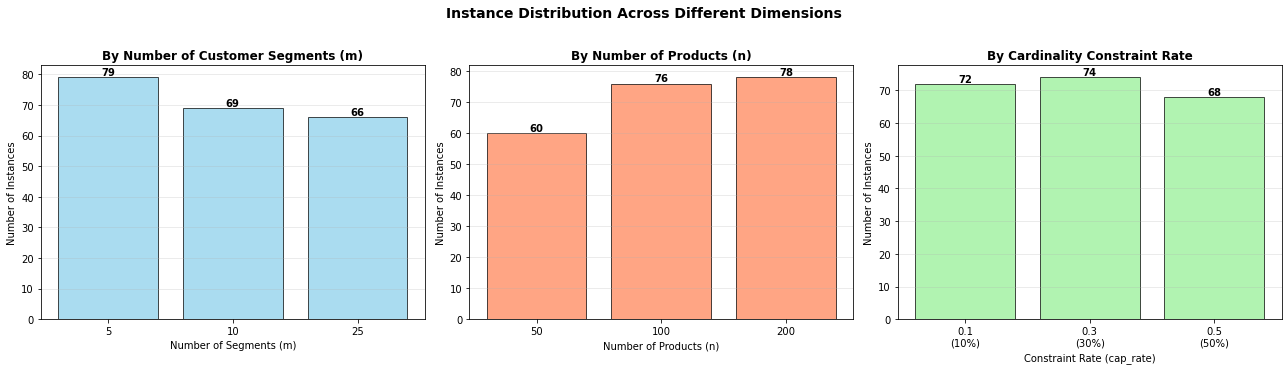

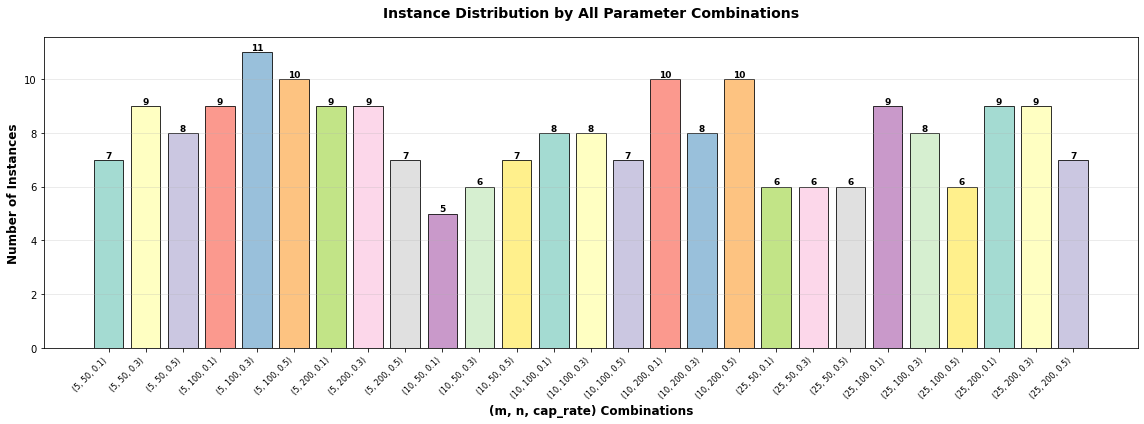

In [3]:
# =============================================================================
# DATA SUMMARY: Group Statistics with Bar Plot
# =============================================================================

print("=" * 80)
print("DATASET STRUCTURE SUMMARY")
print("=" * 80)

# Create summary DataFrame
df_summary = pd.DataFrame([
    {
        'm': inst.m,
        'n': inst.n,
        'cap_rate': inst.cap_rate,
        'seed': inst.seed
    }
    for inst in instances
])

# Group by (m, n, cap_rate) and count
grouped = df_summary.groupby(['m', 'n', 'cap_rate']).size().reset_index(name='num_instances')

# Create bar plot visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Instance Distribution Across Different Dimensions', 
             fontsize=14, fontweight='bold', y=1.02)

# Subplot 1: Distribution by m (number of segments)
m_counts = df_summary['m'].value_counts().sort_index()
axes[0].bar(m_counts.index.astype(str), m_counts.values, 
            color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('By Number of Customer Segments (m)', fontweight='bold')
axes[0].set_xlabel('Number of Segments (m)')
axes[0].set_ylabel('Number of Instances')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(m_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Subplot 2: Distribution by n (number of products)
n_counts = df_summary['n'].value_counts().sort_index()
axes[1].bar(n_counts.index.astype(str), n_counts.values, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('By Number of Products (n)', fontweight='bold')
axes[1].set_xlabel('Number of Products (n)')
axes[1].set_ylabel('Number of Instances')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(n_counts.values):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Subplot 3: Distribution by cap_rate (cardinality constraint)
cap_counts = df_summary['cap_rate'].value_counts().sort_index()
cap_labels = [f'{cap:.1f}\n({int(cap*100)}%)' for cap in cap_counts.index]
axes[2].bar(range(len(cap_counts)), cap_counts.values, 
            color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_title('By Cardinality Constraint Rate', fontweight='bold')
axes[2].set_xlabel('Constraint Rate (cap_rate)')
axes[2].set_ylabel('Number of Instances')
axes[2].set_xticks(range(len(cap_counts)))
axes[2].set_xticklabels(cap_labels)
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(cap_counts.values):
    axes[2].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Additional grouped bar plot by (m, n, cap_rate) combinations
fig, ax = plt.subplots(figsize=(16, 6))

# Create labels for each combination
grouped['label'] = grouped.apply(
    lambda row: f"({int(row['m'])}, {int(row['n'])}, {row['cap_rate']:.1f})", 
    axis=1
)

# Create bar plot
x_pos = np.arange(len(grouped))
bars = ax.bar(x_pos, grouped['num_instances'], 
              color=plt.cm.Set3(np.arange(len(grouped)) % 12),
              edgecolor='black', alpha=0.8)

# Customize plot
ax.set_xlabel('(m, n, cap_rate) Combinations', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
ax.set_title('Instance Distribution by All Parameter Combinations', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(grouped['label'], rotation=45, ha='right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, (bar, val) in enumerate(zip(bars, grouped['num_instances'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            str(val), ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

### 2.2 Run Algorithm on All Instances

In [ ]:
# Initialize data paths and result storage
hard_instance_dir = project_root + "/hard_data/"
rev_method_list = ['RS2', 'RS4']  # Two revenue curve methods to test
results = []

# Loop through each revenue method
for rev_method in rev_method_list:
    # Load instances for the current revenue method
    input_json_path = hard_instance_dir + cardinality_dir + rev_method + "_data.json"
    instances = load_MMNL_instances(input_json_path)
    
    print(f"\nProcessing {rev_method}...")
    
    # Process each instance
    for idx, data in enumerate(instances):
        # Get the revenue function for this instance
        revenue_fn = get_revenue_function_mmnl(data)
        cap = data.cap_rate * data.n
        A,B =  cardinality(data.n,cap)
        # =====================================================================
        # TODO: IMPLEMENT YOUR METHOD HERE
        # =====================================================================
        # Replace the line below with your own algorithm
        # Your method should return a binary vector of length n
        # where 1 means the product is selected, 0 means not selected
        # 
        # The assortment must satisfy the cardinality constraint:
        # sum(best_ass) <= cap_rate * n
        #
        # Example:
        #   best_ass = your_algorithm(data.m, data.n, data.u, data.price, 
        #                             data.v0, data.omega, A,B)
        # =====================================================================
        
        best_ass = None  # Replace this with your method
        
        # Check if method is implemented
        if best_ass is None:
            print("⚠️  Please implement your method in the TODO section above")
            break
        
        # Calculate the revenue achieved by your method
        revenue = revenue_fn(best_ass)[0]
        
        # Get the optimal revenue (from exact solution)
        opt_rev = data.max_rev
        
        # Calculate the optimality gap (in percentage)
        gap_method = (opt_rev - revenue) / opt_rev * 100
        
        # Store results for this instance
        result_dict = {
            'm': data.m,                    # Number of customer segments
            'n': data.n,                    # Number of products
            'rev_method': rev_method,       # Revenue curve method (RS2 or RS4)
            'cap_rate': data.cap_rate,      # Capacity rate
            'seed': data.seed,              # Random seed for reproducibility
            'max_rev': opt_rev,             # Optimal revenue
            'revenue': revenue,             # Revenue from your method
            'gap_method': gap_method        # Optimality gap (%)
        }
        
        results.append(result_dict)
    
    if best_ass is None:
        break

if best_ass is not None:
    print(f"\n✅ Completed testing on {len(results)} instances.")
else:
    print("\n❌ Testing incomplete. Please implement your method first.")


Processing RS2...
⚠️  Please implement your method in the TODO section above

❌ Testing incomplete. Please implement your method first.
